In [1]:
import torch
from TedSeg import *
from cofo import *

In [2]:
SEED = 124
seed_worker, g = set_seed(SEED, desterministic_algorithm=False)

In [3]:
from functools import partial

EXP_NAME = 'kvasir-endo_cofo'
IMG_SIZE = 224
TRAIN_BS = 4*7
LR = 1e-2
N_EPOCHS = 500
ALPHA = 1.0
ALPHA_SCHEDULE = True
EMB_SIZE = 256
BETA = 0.00

OPT_FUNC = partial(torch.optim.SGD, lr=LR, momentum=0.95, nesterov=True)
LR_SCHEDULER = 'COSINE_LR'


# Loss
MODE = 'supervised'
MARGIN = 0.3
MINT_ENT_W = 0.005


METRIC = batch_dice_score

VALIDATE_EVERY = 50
TRAIN_NW = 8

def get_training_augmentation(img_size):
    train_transform = [
        albu.OneOf([
            albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        ]),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(0.05, 0.05, rotate_limit=90, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.2),
        albu.SmallestMaxSize(img_size),
        albu.CenterCrop(img_size, img_size),
    ]
    return albu.Compose(train_transform)

In [4]:
encoder_args = {
    "pretrained":False,           
}
decoder_args = {}


MODEL = CoFoUnet(emb_size=EMB_SIZE, encoder_args=encoder_args)

In [5]:
import pandas as pd

train = pd.read_csv('data/csv/Kvasir_SEG/train.csv')
valid = pd.read_csv('data/csv/EndoTect_2020_Segmentation_Test_Dataset/valid.csv')
test = pd.read_csv('data/csv/EndoTect_2020_Segmentation_Test_Dataset/test.csv')

data_path = 'data/images/kvasir/'
train['image'] = data_path + 'image' + train['image']
train['mask'] = data_path + 'mask' + train['mask']

train_ds = CoFoSegmentationDataset(train, valid, get_training_augmentation, IMG_SIZE)
valid_ds = SegmentationDataset(test, get_validation_augmentation, IMG_SIZE, normalize=False)
test_ds = SegmentationDataset(test, get_validation_augmentation, IMG_SIZE, normalize=False)

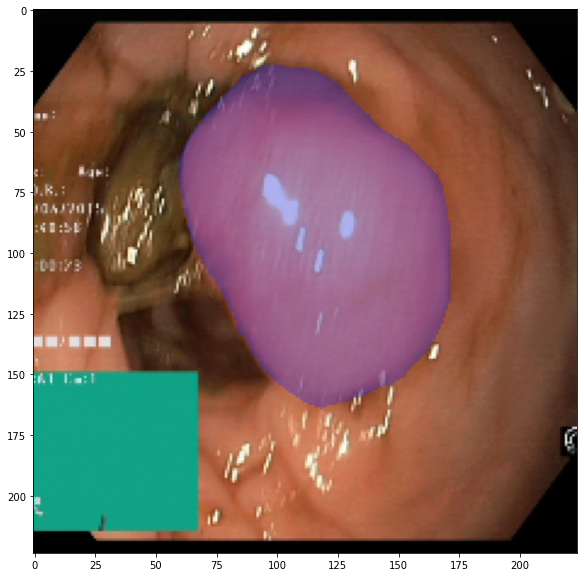

In [6]:
valid_ds.show_img()

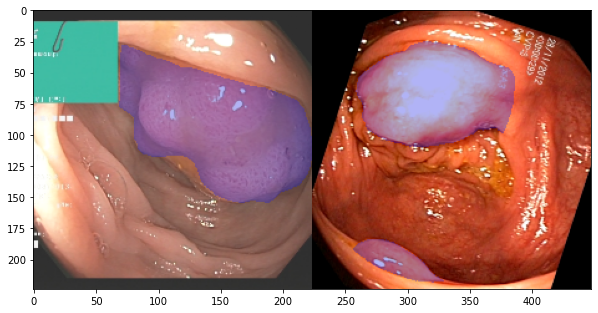

In [7]:
train_ds.show_img()

In [8]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=TRAIN_BS, 
                      shuffle=True, num_workers=TRAIN_NW, pin_memory=True,
                        worker_init_fn=seed_worker,
                        generator=g, drop_last=True)
valid_dl = DataLoader(valid_ds, batch_size=16, 
                      num_workers=4, shuffle=False,
                     worker_init_fn=seed_worker,
                        generator=g, )

In [9]:
learn = CoFoLearner(model=MODEL, data=(train_dl, valid_dl),
                    loss=dice_loss, 
                    name=EXP_NAME, metric=METRIC)

In [10]:
import torch
n_epochs = 1000
optim = OPT_FUNC(learn.model.parameters())

COSINE_LR = partial(torch.optim.lr_scheduler.CosineAnnealingLR, T_max=len(learn.data[0])*N_EPOCHS)
lr_scheduler = eval(LR_SCHEDULER)(optim)

In [11]:
cofo_loss = cofo_loss(mode=MODE, mint_ent_w=MINT_ENT_W, margin=MARGIN)

/home/me/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


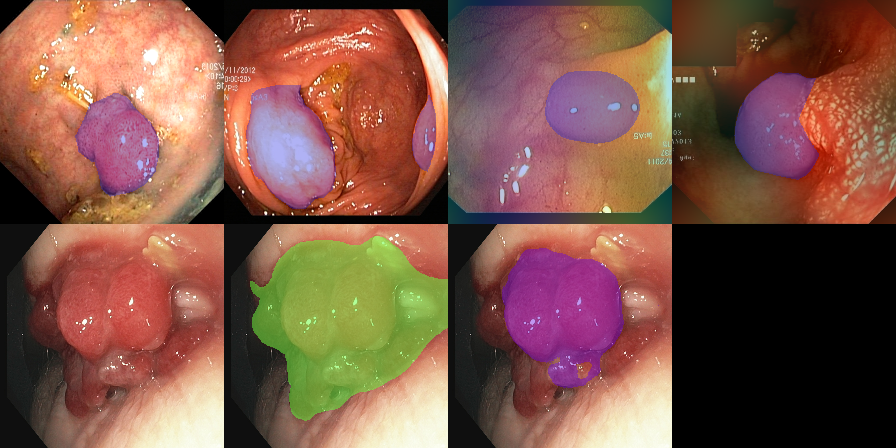

Ep.    0|train_dice_loss: 0.654|train_style_loss: 0.249|train_content_loss: 0.212|valid_loss: 0.672|valid_metric: 0.414 -saved
Ep.   10|train_dice_loss: 0.290|train_style_loss: 0.229|train_content_loss: 0.226|valid_loss: 0.335|valid_metric: 0.612 -saved
Ep.   20|train_dice_loss: 0.211|train_style_loss: 0.227|train_content_loss: 0.221|valid_loss: 0.357|valid_metric: 0.568 
Ep.   30|train_dice_loss: 0.167|train_style_loss: 0.233|train_content_loss: 0.222|valid_loss: 0.297|valid_metric: 0.670 -saved
Ep.   40|train_dice_loss: 0.138|train_style_loss: 0.248|train_content_loss: 0.212|valid_loss: 0.293|valid_metric: 0.671 -saved
Ep.   50|train_dice_loss: 0.107|train_style_loss: 0.240|train_content_loss: 0.237|valid_loss: 0.204|valid_metric: 0.776 -saved
Ep.   60|train_dice_loss: 0.097|train_style_loss: 0.248|train_content_loss: 0.224|valid_loss: 0.258|valid_metric: 0.726 
Ep.   70|train_dice_loss: 0.087|train_style_loss: 0.253|train_content_loss: 0.243|valid_loss: 0.197|valid_metric: 0.802 -sa

In [ ]:
learn.fit(1000, optim, lr_scheduler,
          cofo_loss=cofo_loss,
          beta=0.01,
          contrastive=True,
          alpha=1.0, alpha_content=1.0,
          schedule_alpha=True,
          scheduler_mode='iteration', validate_every=10)#VALIDATE_EVERY)

In [13]:
test = pd.read_csv('data/csv/EndoTect_2020_Segmentation_Test_Dataset/test.csv')
test_ds = SegmentationDataset(test, get_validation_augmentation, IMG_SIZE, normalize=False)
test_loader = DataLoader(test_ds, 4, num_workers=4)


learn.get_dice_score(test_loader)

0.8435712